<a href="https://colab.research.google.com/github/sflyranger/finetuning-encoder-decoder-models-sequence-classification/blob/main/llama_3_2_3B_it_Multilabel__emotion_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color = 'pickle'>**Multilabel Generation with LLama-3.2-3B-instruction-tuned**

The purpose of this notebook is to finetune the **LLama-3.2-3B-instruction-tuned** model for emotion detection on a small dataset.

- Based on my past experiences using both RNN and BERT models, I plan on using a similar strategy to account for the class imbalance present in this dataset.

- This will be done using **K-fold stratified sampling** to create my splits such that the class distribution represents that of the training set.

- Instead of modifying the architecture by replacing the language head with a classification head, I will **retain the language head** of the instruction-tuned model and use it to generate the emotion labels directly.

- The training will follow a standard model training process as shown below.

---

## <font color = 'pickle'>**Training Plan**

1. **Set the Environment**

2. **Load the Dataset**

3. **Manipulate the Splits of the Dataset**
   - Use stratified K-fold sampling to maintain class balance in splits.

4. **Load the Pretrained Tokenizer**

5. **Create a Function for the Tokenizer**

6. **Train the Model**
   - 6.1. Download the model
   - 6.2. PEFT Setup
   - 6.3. Compute the metric function (ensuring we account for multilabel, e.g., Binary Cross Entropy)
   - 6.4. Define Training Arguments
   - 6.5. Instantiate the Trainer
   - 6.6. Setup Weights & Biases (WANDB)
   - 6.7. Training and Validation
   - 6.8. Generate labels using the **instruction-tuned language head**.

7. **Model Inference**


# <font color='pickle'>**1. Set the Environment**

In [ ]:
import sys

# Check if running in Google Colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    # Mount Google Drive with force_remount to avoid mounting issues
    drive.mount('/content/drive', force_remount=True)

    # Set the base path to a Google Drive folder
    base_path = '/content/drive/MyDrive/Colab Notebooks'

    # Install necessary packages
    print("Installing required libraries...")
    !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes trl -U -qq
    !pip install iterative-stratification -qq

    print("All packages installed successfully.")

# No need to force restart the runtime as this approach aligns with Colab's auto-resolved environment



Mounted at /content/drive
Installing required libraries...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.3/336.3 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB

<font color = 'pickle'>***Loading Libraries***

In [ ]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import gc
import time
from typing import Dict, List, Union, Optional, Tuple
import json
import itertools
from datetime import datetime
from difflib import get_close_matches
import os
import sys

from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib

import torch
import torch.nn as nn
import ast
from tqdm import tqdm

# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

import wandb
from google.colab import userdata
from huggingface_hub import login

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
set_seed(42)

In [ ]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')

In [ ]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")


Successfully logged in to Hugging Face!


In [ ]:
if wandb_api_key:
  wandb.login(key=wandb_api_key)
  print("Successfully logged in to WANDB!")
else:
    print("WANDB key not found in notebook secrets.")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: the-steven-e (the-steven-e-the-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged in to WANDB!


In [ ]:
# Setting up paths
base_folder = Path(base_path)
data_folder = base_folder/'datasets/emotion_detection_ds'
model_folder = base_folder/'models/nlp_fall_2024/gemma-3.2-3B-it'

model_folder.mkdir(exist_ok =True, parents = True)

# <font color='pickle'>**2. Load the Dataset**

In [ ]:
train_valid_df = pd.read_csv(data_folder/'train.csv')
train_valid_df.head(5)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
train_val_labels = train_valid_df[['anger',
                                      'anticipation',
                                             'disgust',
                                             'fear',
                                             'joy',
                                             'love',
                                             'optimism',
                                             'pessimism',
                                             'sadness',
                                             'surprise',
                                             'trust']]

<font color = 'pickle'>***Plotting to show the class imbalance***

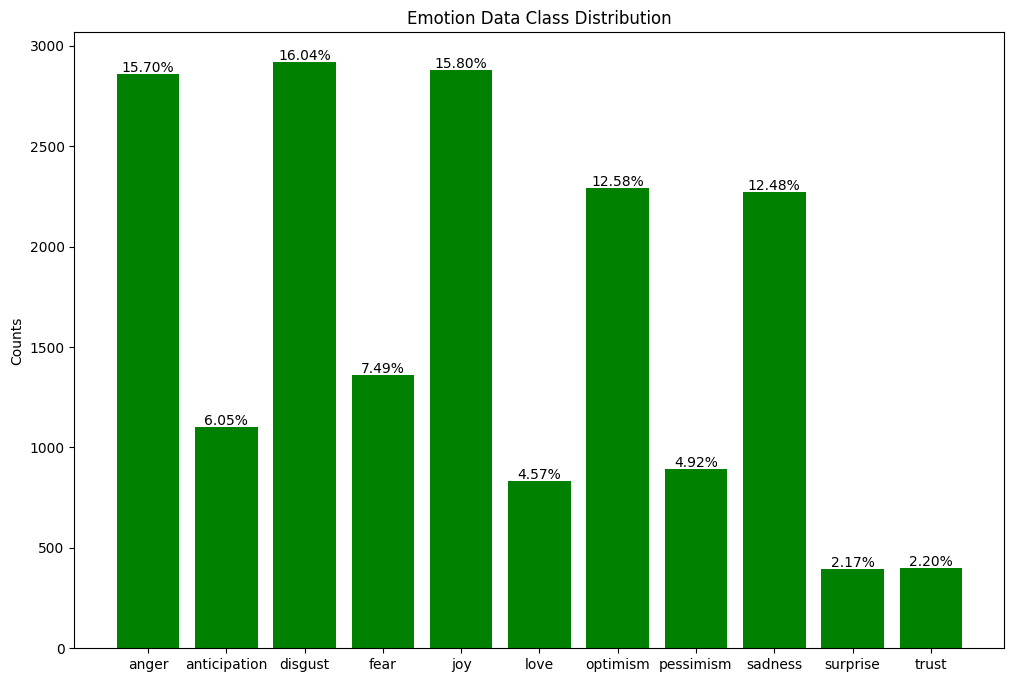

In [ ]:
# getting the count for the labels
label_counts = train_val_labels.sum()
#getting the count overall
total_count = label_counts.sum()
# getting the percentages
percentages = (label_counts/total_count)*100

plt.figure(figsize = (12,8))
plt.bar(label_counts.index, label_counts.values, color = 'green')

for i , (count, pct) in enumerate(zip(label_counts.values, percentages)):
  plt.text(i, count+10, f'{pct:.2f}%', ha = 'center')

plt.title('Emotion Data Class Distribution')
plt.ylabel('Counts')
plt.show()

In [ ]:
label_counts

,0
anger,2859
anticipation,1102
disgust,2921
fear,1363
joy,2877
love,832
optimism,2291
pessimism,895
sadness,2273
surprise,396


# <font color='pickle'>**3. Manipulate the Splits of the Dataset**

In [ ]:
mkf = MultilabelStratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

X = train_valid_df['Tweet'].values
y = train_val_labels.values

for train_index, valid_index in mkf.split(X, y):
  X_train, X_val = X[train_index], X[valid_index]
  y_train, y_val = y[train_index], y[valid_index]


In [ ]:
train_df = train_valid_df.iloc[train_index] # pulling the training indices from the split
val_df = train_valid_df.iloc[valid_index] # pulling the valid indices from the split

In [ ]:
train_df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
val_df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
8,2017-41344,it's pretty depressing when u hit pan on ur fa...,0,0,1,0,0,0,0,0,1,0,0
10,2017-40158,Making that yearly transition from excited and...,0,0,1,0,0,0,0,1,1,0,0
14,2017-11274,@bt_uk broadband is shocking regretting signin...,1,0,1,0,0,0,0,0,0,0,0
16,2017-11475,@BitchestheCat Look at those teef! #growl,1,0,1,1,0,0,0,0,0,0,0
17,2017-10989,Star trek online has a update to download oh f...,1,0,1,0,1,0,0,0,1,0,0


In [ ]:
train_labels = train_df[['anger',
                         'anticipation',
                         'disgust',
                         'fear',
                         'joy',
                         'love',
                         'optimism',
                         'pessimism',
                         'sadness',
                         'surprise',
                         'trust']]

In [ ]:
train_labels.sum()

,0
anger,1906
anticipation,734
disgust,1947
fear,909
joy,1918
love,554
optimism,1528
pessimism,596
sadness,1515
surprise,264


<font color = 'pickle'>***Plotting the training and validation class distributions to check the split.***

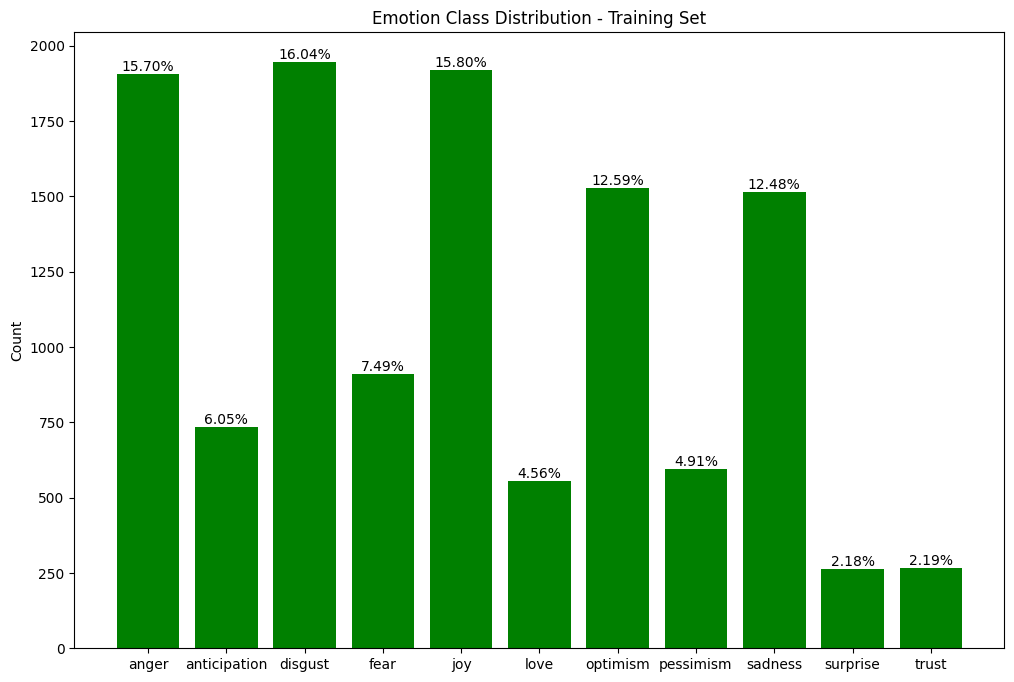

In [ ]:
label_counts_t = train_labels.sum()

total_count_t = label_counts_t.sum()

percentages = (label_counts_t/total_count_t)*100

plt.figure(figsize = (12,8))
plt.bar(label_counts_t.index, label_counts_t.values, color = 'green')

for i, (count, pct) in enumerate(zip(label_counts_t.values, percentages)):
  plt.text(i, count+10, f'{pct:.2f}%', ha = 'center')

plt.title('Emotion Class Distribution - Training Set')
plt.ylabel('Count')
plt.show()

In [ ]:
val_labels = val_df[['anger',
                         'anticipation',
                         'disgust',
                         'fear',
                         'joy',
                         'love',
                         'optimism',
                         'pessimism',
                         'sadness',
                         'surprise',
                         'trust']]

In [ ]:
val_labels.sum()

,0
anger,953
anticipation,368
disgust,974
fear,454
joy,959
love,278
optimism,763
pessimism,299
sadness,758
surprise,132


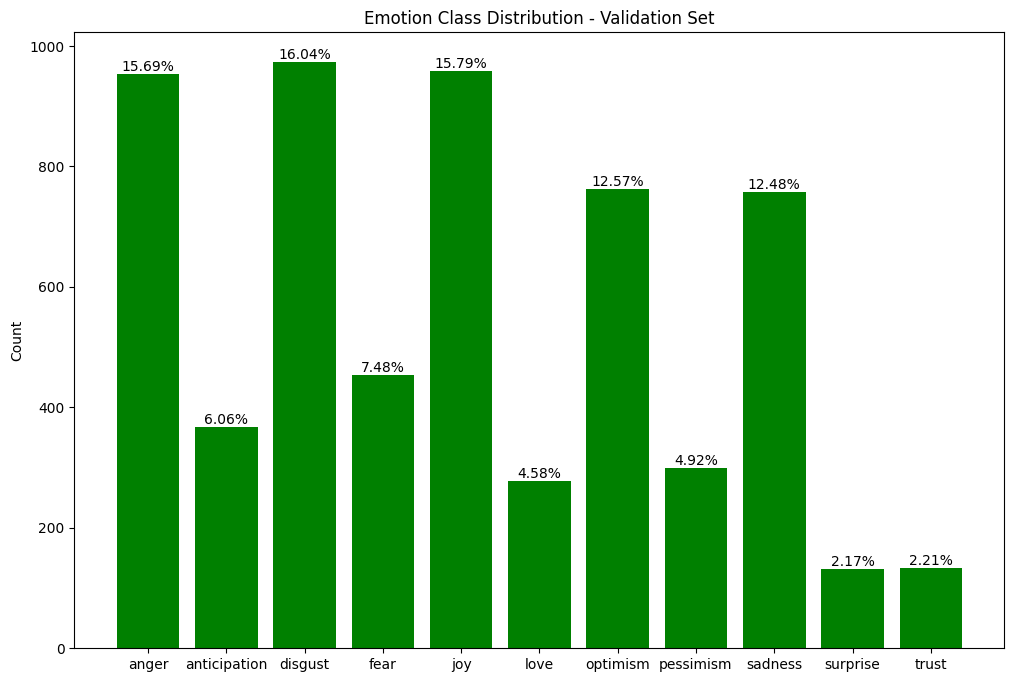

In [ ]:
# plotting to see the distribution for the validation set
label_counts_v = val_labels.sum()

total_counts_v = label_counts_v.sum()

percentages = (label_counts_v/total_counts_v)*100

plt.figure(figsize = (12,8))
plt.bar(label_counts_v.index, label_counts_v.values, color = 'green')

for i, (count, pct) in enumerate(zip(label_counts_v.values, percentages)):
  plt.text(i, count+5, f'{pct:.2f}%', ha = 'center')

plt.title('Emotion Class Distribution - Validation Set')
plt.ylabel('Count')
plt.show()

In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
X_train = X_train.tolist()
X_val = X_val.tolist()

In [ ]:
X_train[0]

"“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry"

In [ ]:
y_train[0]

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1])

In [ ]:
class_names = ['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

In [ ]:
# Map the binary array to class names
def map_binary_to_classes(binary_array, class_names):
    # Iterate through each sample (row) in the binary array
    mapped_samples = []
    for sample in binary_array:
        mapped_samples.append([class_names[i] for i in range(len(sample)) if sample[i] == 1])
    return mapped_samples

# Apply the mapping
y_train_mapped = map_binary_to_classes(y_train, class_names)
y_val_mapped = map_binary_to_classes(y_val, class_names)

print(f"Mapped y_train: {y_train_mapped}")
print(f"Mapped y_val: {y_val_mapped}")

Mapped y_train: [['anticipation', 'optimism', 'trust'], ['joy', 'love', 'optimism'], ['anger', 'disgust', 'joy', 'optimism'], ['joy', 'optimism'], ['anger', 'disgust'], ['joy'], ['anticipation', 'pessimism'], ['anger', 'disgust'], ['anger', 'disgust'], [], ['joy', 'love'], ['anger', 'sadness'], ['anger', 'disgust', 'sadness'], ['anger', 'disgust', 'sadness'], ['anger', 'disgust'], ['anger', 'disgust'], ['anger', 'disgust', 'fear', 'sadness'], ['anger', 'disgust'], ['joy', 'optimism'], ['anger', 'disgust', 'joy'], ['fear', 'joy', 'love', 'optimism'], ['anger', 'disgust'], ['anger', 'disgust', 'joy', 'optimism'], ['anger', 'disgust', 'sadness', 'surprise'], ['anticipation', 'joy', 'optimism'], ['joy', 'love', 'optimism'], ['anticipation', 'joy', 'sadness'], ['love', 'optimism', 'trust'], ['sadness'], ['optimism', 'pessimism', 'sadness'], ['anger', 'disgust'], ['anger', 'disgust'], ['anger', 'disgust', 'fear'], ['joy', 'love'], ['anger', 'anticipation'], ['anticipation', 'fear', 'optimism

<font color = 'pickle'>***Setting up the datasets for the HF trainer***

In [ ]:
trainset = Dataset.from_dict(
    {
    'text':X_train,
    'label':y_train_mapped
    })
validset = Dataset.from_dict({
    'text': X_val,
    'label':y_val_mapped
})

In [ ]:
trainset

Dataset({
    features: ['text', 'label'],
    num_rows: 5150
})

In [ ]:
trainset[0]

{'text': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'label': ['anticipation', 'optimism', 'trust']}

In [ ]:
validset

Dataset({
    features: ['text', 'label'],
    num_rows: 2574
})

In [ ]:
validset[0]

{'text': "it's pretty depressing when u hit pan on ur favourite highlighter",
 'label': ['disgust', 'sadness']}

<font color = 'pickle'>***Final Dataset***

In [ ]:
# compiling the trainset and validset into another dataset
train_val = DatasetDict({'train':trainset, 'valid':validset})

In [ ]:
train_val

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 5150
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 2574
    })
})

In [ ]:
train_val['train'][0]

{'text': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'label': ['anticipation', 'optimism', 'trust']}

In [ ]:
train_val['valid'][0]

{'text': "it's pretty depressing when u hit pan on ur favourite highlighter",
 'label': ['disgust', 'sadness']}

# <font color='pickle'>**4. Load the Pretrained Tokenizer**

## <font color='pickle'>**The Difference Between an Instruction-Tuned Model and a Standard Sequence Classification Model**

- The key distinction between these models lies in their purpose:
  - **Instruction-Tuned Model**: Designed to generate text-based labels. It takes a set of instructions along with the text and uses the decoder's language head to generate labels based on the instructions provided.
  - **Sequence Classification Model**: Tailored to provide predefined classifications. It removes the language head and replaces it with a classification head that predicts labels directly using a `label2id` or `id2label` mapping in the configuration.

- **Quantization** is a shared feature for both models, which I have applied in all prior versions in this repo. Here's a quick refresher:
  - Quantization reduces the precision of model values to save memory and optimize performance.
  - Standard models use 32-bit floating-point precision for training, whereas **QLoRA** (Quantized Low Rank Adaptation) uses 8-bit or even 4-bit precision to represent model weights.
  - This reduced precision makes the model more memory-efficient, which is especially ideal for environments like Colab.

- **How QLoRA Works**:
  - It freezes the original model weights and trains two smaller matrices of values, which are added to the original weights for fine-tuning. This approach is particularly effective for fine-tuning linear layers in the model.
  - This process significantly reduces the resource requirements for fine-tuning while retaining model performance.

For further details, refer to the [Original QLoRA Paper](https://arxiv.org/abs/2305.14314).

- In summary, instruction-tuned models excel in generating text-based outputs using the language head, while sequence classification models focus on directly classifying text through a specialized classification head. Both approaches can leverage quantization for more efficient training and inference.


In [ ]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")

In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
checkpoint = 'meta-llama/Llama-3.2-3B-Instruct'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [ ]:
tokenizer.eos_token

'<|eot_id|>'

In [ ]:
tokenizer.pad_token

No pad token found, so I will add one

In [ ]:
tokenizer.pad_token = '<|finetune_right_pad_id|>'

In [ ]:
tokenizer.pad_token

'<|finetune_right_pad_id|>'

In [ ]:
tokenizer.pad_token_id

128004

In [ ]:
tokenizer.padding_side

'right'

In [ ]:
tokenizer.chat_template

'{{- bos_token }}\n{%- if custom_tools is defined %}\n    {%- set tools = custom_tools %}\n{%- endif %}\n{%- if not tools_in_user_message is defined %}\n    {%- set tools_in_user_message = true %}\n{%- endif %}\n{%- if not date_string is defined %}\n    {%- if strftime_now is defined %}\n        {%- set date_string = strftime_now("%d %b %Y") %}\n    {%- else %}\n        {%- set date_string = "26 Jul 2024" %}\n    {%- endif %}\n{%- endif %}\n{%- if not tools is defined %}\n    {%- set tools = none %}\n{%- endif %}\n\n{#- This block extracts the system message, so we can slot it into the right place. #}\n{%- if messages[0][\'role\'] == \'system\' %}\n    {%- set system_message = messages[0][\'content\']|trim %}\n    {%- set messages = messages[1:] %}\n{%- else %}\n    {%- set system_message = "" %}\n{%- endif %}\n\n{#- System message #}\n{{- "<|start_header_id|>system<|end_header_id|>\\n\\n" }}\n{%- if tools is not none %}\n    {{- "Environment: ipython\\n" }}\n{%- endif %}\n{{- "Cutting

# System Setup

## Purpose
This section initializes the conversation context by handling:
- The beginning-of-sequence token (`bos_token`).
- Dynamic date settings.
- Definition of tools and environment parameters.

## Key Features
- **`bos_token`**: Marks the beginning of the interaction.
- **Date Handling**:
  - If `date_string` is undefined:
    - Sets it using `strftime_now` if available.
    - Defaults to "26 Jul 2024" otherwise.
- **Tools Setup**:
  - If tools are provided, they are configured for subsequent use.
  - If `tools_in_user_message` is undefined, it defaults to `True`.

## Example
```markdown
<|start_header_id|>system<|end_header_id|>
Environment: ipython
Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024
<|eot_id|>
```

---

### 2. **System Message Markdown**
```markdown
# System Message

## Purpose
Extracts and formats the system message to be incorporated into the conversation context.

## Key Features
- Checks if the first message is from the system.
- Assigns it to `system_message` and removes it from the remaining messages.
- Formats the system message with header and end-of-token markers.

## Example
```markdown
<|start_header_id|>system<|end_header_id|>
Environment: ipython
Today Date: 26 Jul 2024
<|eot_id|>
```

---

### 3. **Tool Guidance in User Messages**
```markdown
# Tool Guidance in User Messages

## Purpose
Integrates tools into user messages, providing clear guidance on their usage.

## Key Features
- Extracts the first user message.
- Includes instructions for tool calls:
  - Respond in JSON format with `name` and `parameters`.
- Lists all tools in JSON for reference.

## Example
```markdown
<|start_header_id|>user<|end_header_id|>
Given the following functions, please respond with a JSON for a function call with its proper arguments that best answers the given prompt.
Respond in the format {"name": function name, "parameters": dictionary of argument name and its value}.
Do not use variables.

<tool_descriptions_here>

<|eot_id|>
```

---

### 4. **Message Formatting**
```markdown
# Message Formatting

## Purpose
Processes and formats each message in the conversation based on its role.

## Key Features
- **Roles**:
  - Handles roles like `system`, `user`, `assistant`, `tool`, and `ipython`.
  - Wraps messages with headers (`<|start_header_id|>` and `<|end_header_id|>`).
- **Content**:
  - Trims and formats message content for clean representation.
  - Ensures compatibility with downstream tokenization.

## Example
```markdown
<|start_header_id|>user<|end_header_id|>
Hello, how can I use tools in this system?
<|eot_id|>
```


---

### 5. **Tool Call Formatting**
```markdown
# Tool Call Formatting

## Purpose
Processes tool-related messages and ensures proper formatting for execution.

## Key Features
- Supports only single tool calls.
- Verifies the structure and raises exceptions for violations.
- Formats tool calls in JSON:
  - Includes tool `name` and `parameters`.

## Example
```markdown
<|start_header_id|>assistant<|end_header_id|>
{"name": "example_tool", "parameters": {"arg1": "value1", "arg2": "value2"}}
<|eot_id|>
```

---

### 6. **Ipython Role Handling**
```markdown
# Ipython Role Handling

## Purpose
Processes messages with the `ipython` role, converting their content to JSON if iterable or mapping.

## Key Features
- Formats messages for compatibility with tokenization.
- Handles non-mappable content directly.

## Example
```markdown
<|start_header_id|>ipython<|end_header_id|>
{"key": "value"}
<|eot_id|>
```

---

### 7. **Prompt Generation**
```markdown
# Prompt Generation

## Purpose
Adds a generation prompt for the assistant role if `add_generation_prompt` is enabled.

## Key Features
- Ensures the assistant role is prepared for tokenization or inference.
- Adds necessary formatting for token compatibility.

## Example
```markdown
<|start_header_id|>assistant<|end_header_id|>
<|eot_id|>
```



<font color = 'pickle'>***I will be focusing on the prompt generation portion using the assistant role.***

# <font color='pickle'>**5. Create prompts for the Tokenizer**

- This function formats prompts from me (the user) to the assistant (the model) for generating labels for each document.
  
- The process starts by setting up an instruction that:
  - Tells the model to classify the text based on a list of predefined labels.
  - Instructs the model to select the applicable labels for the document.
  
- Then, the function:
  - Provides the document (from the example) to be classified.
  - Prepares the messages to send to the model.

- After that, the `apply_chat_template` function is called on the tokenizer with the messages.
  - The documents aren't fully tokenized; they’re passed in as a whole so that classification can happen.


In [ ]:
def format_chat(example):
  instruction = f"Classify the TEXT by selecting all applicable labels from the following list: {class_names}. \n\nTEXT:{example['text']}"
  messages = [
      {'role':'user','content': instruction},
      {'role':'assistant', 'content': f"{example['label']}"}
  ]
  return {'text':tokenizer.apply_chat_template(messages, tokenize = False)}

In [ ]:
train_val_chat = train_val.map(format_chat)

Map:   0%|          | 0/5150 [00:00<?, ? examples/s]

Map:   0%|          | 0/2574 [00:00<?, ? examples/s]

In [ ]:
# check the dictionary format
train_val_chat

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 5150
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 2574
    })
})

In [ ]:
# look at one observation to check prompt formatting was properly mapped
train_val_chat['train'][0]

{'text': "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 07 Dec 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']. \n\nTEXT:“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n['anticipation', 'optimism', 'trust']<|eot_id|>",
 'label': ['anticipation', 'optimism', 'trust']}

In [ ]:
train_val_chat['valid'][0]

{'text': "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 07 Dec 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']. \n\nTEXT:it's pretty depressing when u hit pan on ur favourite highlighter<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n['disgust', 'sadness']<|eot_id|>",
 'label': ['disgust', 'sadness']}

## <font color = 'pickle'>**5.1 Filter Long Sentences**

- <font color = 'pickle'>***Note:***</font> The function below is used to filter out documents with sequences longer than 1000 tokens. While there are none in my current dataset, I am preparing this function for future work with longer documents.

- Documents with a sequence length longer than 1000 tokens can cause issues, especially when using instruction-tuned models with prompts.

   - **Why?** Instruction-tuned models are optimized to process a specific context length, typically constrained by token limits. When documents exceed this limit, they may not be processed correctly, leading to truncated input or a loss of important context.
   
   - **Problems include:**
     - **Truncation of Input:** Any content beyond the token limit is discarded, potentially cutting off critical information.
     - **Context Loss:** Instruction-tuned models rely on the entire input sequence to understand and generate accurate responses. Exceeding the token limit may result in incomplete or inaccurate predictions because the model loses part of the context.
     - **Processing Delays:** Longer sequences take more computation time and memory, potentially leading to slower processing or even out-of-memory errors, depending on the model's infrastructure.


In [ ]:
def check_length(example):
  encoding = tokenizer.encode(example['text'])
  return len(encoding)<=1000

# get the documents over the length
train_filtered = train_val_chat['train'].filter(check_length)
valid_filtered = train_val_chat['valid'].filter(check_length)

# print the transitions
print(f"Train: {len(train_val_chat['train'])}-> {len(train_filtered)}")
print(f"Valid: {len(train_val_chat['valid'])}-> {len(valid_filtered)}")

Filter:   0%|          | 0/5150 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2574 [00:00<?, ? examples/s]

Train: 5150-> 5150
Valid: 2574-> 2574


# <font color='pickle'>**6. Train the Model**

## <font color='pickle'>**6.1 Download the Model**

In [ ]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [ ]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = 'nf4',
    bnb_4bit_use_double_quant = True,
    bnb_4bit_compute_dtype = torch_data_type,
    bnb_4bit_quant_storage = torch_data_type
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config = bnb_config,
                                             torch_dtype = torch_data_type,
                                             trust_remote_code = True, )

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [ ]:
model.get_input_embeddings()

Embedding(128256, 3072)

In [ ]:
len(tokenizer)

128256

## <font color='pickle'>**6.2 PEFT Setup**

In [ ]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e

In [ ]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [ ]:
find_linear_layers(model)

['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'lm_head']


['up_proj',
 'down_proj',
 'q_proj',
 'v_proj',
 'lm_head',
 'o_proj',
 'gate_proj',
 'k_proj']

In [ ]:
TaskType.CAUSAL_LM

<TaskType.CAUSAL_LM: 'CAUSAL_LM'>

In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model, peft_config )
#lora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

trainable params: 194,510,848 || all params: 3,407,260,672 || trainable%: 5.7087


In [ ]:
lora_model.get_input_embeddings()

Embedding(128256, 3072)

## <font color='pickle'>**6.3 Define Training Arguments**

In [ ]:
run_name = 'LLama-3.2-3B-it-emotion-exp1'
use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# Configure training parameters
training_args = SFTConfig(
    seed = 42,
    # Training-specific configurations
    num_train_epochs=3,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=5e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=50,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=50,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=50,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16=use_fp16 ,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)

In [ ]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    model.config.use_cache = False  # Disable caching for compatibility

model.config

LlamaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "meta-llama/Llama-3.2-3B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 24,
  "num_hidden_layers": 28,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6

## <font color='pickle'>**6.4 Instantiate the Trainer**

In [ ]:

data_collator_comp = DataCollatorForCompletionOnlyLM(tokenizer = tokenizer,
                                                     mlm = False,
                                                     response_template = 'assistant<|end_header_id|>')
trainer = SFTTrainer(
    model=model,
    args = training_args,
    train_dataset = train_filtered,
    eval_dataset = valid_filtered,
    peft_config = peft_config,
    packing = False,
    data_collator = data_collator_comp
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:309: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/5150 [00:00<?, ? examples/s]

Map:   0%|          | 0/2574 [00:00<?, ? examples/s]

In [ ]:
len(tokenizer)

128256

In [ ]:
model.get_input_embeddings()

Embedding(128256, 3072)

## <font color='pickle'>**6.5 Setup Weights & Biases (WANDB)**

In [ ]:
%env WANDB_PROJECT = multilabel_emotion_llama_it

env: WANDB_PROJECT=multilabel_emotion_llama_it


## <font color='pickle'>**6.6 Training and Validation**

### <font color='pickle'>**6.6.1 Training**

In [ ]:
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Optionally, you can retry the operation here after freeing up memory
        # Example retry:
        # trainer.train()
    else:
        raise e

Step,Training Loss,Validation Loss
50,0.354100,0.297910
100,0.291300,0.289293
150,0.278000,0.276995
200,0.244000,0.276084
250,0.231000,0.272313
300,0.232200,0.268713
350,0.212400,0.288416
400,0.181200,0.295132
450,0.186000,0.287770


In [ ]:
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]

In [ ]:
best_model_checkpoint_step

'300'

## <font color='pickle'>**6.7 Generate Labels Using the Instruction-Tuned Language Head**

### <font color='pickle'>**6.7.1 Validation**

In [ ]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/drive/MyDrive/Colab Notebooks/models/nlp_fall_2024/gemma-3.2-3B-it/checkpoint-300'

In [ ]:
from peft import AutoPeftModelForCausalLM, PeftConfig

- The `base_model_name` is pulled from the `PeftConfig` to get the original model architecture used before fine-tuning on my dataset.
- This ensures the tokenizer and model are aligned with the base model, allowing for proper inference and consistency after fine-tuning.




In [ ]:
free_gpu_memory()
model = AutoPeftModelForCausalLM.from_pretrained(
    checkpoint,
    quantization_config=bnb_config,
    torch_dtype=torch_data_type,
    trust_remote_code=True,
    device_map='auto'
)
model.device
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = '<|finetune_right_pad_id|>'
tokenizer.padding_side = 'left'

GPU memory has been freed.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def format_chat_inference(example):
    instruction = f"Classify the TEXT by selecting all applicable labels from the following list: {class_names}.\n\nTEXT: {example['text']}"
    messages = [
        {"role": "user", "content": instruction}
    ]
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt = True)
    return {"text": text}

In [ ]:
valid = train_val['valid'].map(format_chat_inference)

Map:   0%|          | 0/2574 [00:00<?, ? examples/s]

In [ ]:
# this step is not needed for this dataset but is here for future workflows
valid_filtered = valid.filter(check_length)

Filter:   0%|          | 0/2574 [00:00<?, ? examples/s]

In [ ]:
valid_filtered['text'][:5]

["<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 07 Dec 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'].\n\nTEXT: it's pretty depressing when u hit pan on ur favourite highlighter<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n",
 "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 07 Dec 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'].\n\nTEXT: Making that yearly transition from excited and hopeful college returner to sick and exhausted

In [ ]:
valid_filtered['label'][:3]

[['disgust', 'sadness'],
 ['disgust', 'pessimism', 'sadness'],
 ['anger', 'disgust']]

In [ ]:
print(f"Tokenizer vocab size: {len(tokenizer)}")
print(f"Model vocab size: {model.config.vocab_size}")

Tokenizer vocab size: 128256
Model vocab size: 128256


# Function Documentation: `run_inference_instruction`

## Purpose
The `run_inference_instruction` function is designed to perform inference using a language model on a dataset. It processes text inputs in batches, generates outputs based on model predictions, and provides a structured result that includes the input text, the model's output, and (optionally) the ground truth labels. The function supports saving these results to a file for further analysis or debugging.

---

## Parameters

| **Parameter**              | **Type**               | **Description**                                                                                     |
|----------------------------|------------------------|-----------------------------------------------------------------------------------------------------|
| `seed`                     | `int`                 | Random seed to ensure reproducibility of the results.                                               |
| `dataset`                  | `Union[Dict, List]`   | Input dataset, where each element is a dictionary or object containing input text and (optionally) expected outputs. |
| `model`                    | Model object          | The language model used for generating predictions.                                                 |
| `tokenizer`                | Tokenizer object      | Tokenizer used to preprocess the input text into model-readable format.                            |
| `per_device_batch_size`    | `int`                 | Number of samples processed per batch during inference.                                            |
| `input_field`              | `str`                 | Name of the field in the dataset containing input text.                                             |
| `output_field`             | `str`                 | Name of the field in the dataset containing expected outputs (ground truth).                        |
| `save_dir`                 | `Optional[Path]`      | Directory where the generated outputs will be saved.                                                |
| `save_file_name`           | `Optional[str]`       | Name of the file for saving the results. If not specified, a timestamped filename is generated.     |
| `max_new_tokens`           | `int`                 | Maximum number of new tokens the model can generate per input. Default is 20.                      |
| `num_beams`                | `int`                 | Number of beams for beam search. Higher values improve result diversity but increase computation cost. |
| `do_sample`                | `bool`                | Whether to use sampling for generation instead of deterministic decoding. Default is `False`.       |
| `top_k`                    | `int`                 | Limits sampling to the top `k` most likely tokens. Used when `do_sample` is `True`.                 |
| `top_p`                    | `float`               | Nucleus sampling: considers only the smallest set of tokens whose cumulative probability exceeds `top_p`. |
| `temperature`              | `float`               | Adjusts the randomness of predictions. Lower values make results more deterministic, while higher values add diversity. |
| `no_repeat_ngram_size`     | `int`                 | Prevents repetition of n-grams of this size in the generated output, improving coherence.            |
| `num_return_sequences`     | `int`                 | Number of sequences to return for each input. Default is 1.                                         |

---

## Returns
A list of dictionaries, each containing:
- **`input`**: The original input text.
- **`generated_output`**: The text generated by the model.
- **`ground_truth`**: The expected output (if available) from the dataset or `'N/A'` if not provided.

---

## Function Workflow

### 1. **Setup**
- **Seed Initialization**: Sets the random seed using the `set_seed()` function for reproducible results.
- **Model Configuration**: Puts the model into evaluation mode using `model.eval()` and determines the appropriate computing device (e.g., GPU or CPU).
- **Batch Size**: Configures the number of samples to process at a time (`per_device_batch_size`).

### 2. **Batch Processing**
- Iterates over the dataset in batches, determined by `per_device_batch_size`.
- For each batch:
  1. Extracts the input text using the specified `input_field`.
  2. Extracts the ground truth (if available) using `output_field`; defaults to `'N/A'` if the field is not present.
  3. Tokenizes the input text using the provided tokenizer and converts it into PyTorch tensors, padding as necessary for uniform input length.
  4. Moves the tensors to the computing device (e.g., GPU).

### 3. **Generation**
- Performs inference using the `model.generate()` method, applying parameters such as:
  - **`max_new_tokens`**: Controls the maximum length of the generated text.
  - **`num_beams`**: Determines the number of beams for beam search to balance diversity and quality.
  - **`do_sample`**: Enables sampling for stochastic outputs if set to `True`.
  - **`top_k` and `top_p`**: Manage token selection probabilities when sampling.
  - **`temperature`**: Adjusts the "sharpness" of token probabilities.
  - **`no_repeat_ngram_size`**: Prevents repetitive patterns in the output.
- Decodes the generated tokens back into readable text using `tokenizer.batch_decode()`.

### 4. **Result Compilation**
- Constructs a dictionary for each input containing:
  - Input text.
  - Generated output.
  - Ground truth labels (if available).
- Appends the dictionary to the `inference_results` list.

### 5. **Error Handling**
- Captures and logs any errors during batch processing, ensuring the function continues processing subsequent batches.

### 6. **Saving Results (Optional)**
- If `save_dir` is specified:
  - Creates the directory (if it doesn't exist).
  - Saves the results as a JSON file, with the name either provided by `save_file_name` or generated using the current timestamp.

### 7. **Return**
- Returns the `inference_results` list, which contains all the inputs, generated outputs, and ground truth labels.



In [ ]:
def run_inference_instruction(
    seed:int,
    dataset: Union[Dict, List],
    model,
    tokenizer,
    per_device_batch_size:int,
    input_field: str,
    output_field:str,
    save_dir: Optional[Path]=None,
    save_file_name: Optional[str] = None,
    max_new_tokens: int = 20,
    num_beams: int = 1,
    do_sample: bool = False,
    top_k: int = 50,
    top_p: float = 1.0,
    temperature: float = 1.0,
    no_repeat_ngram_size: int = 2,
    num_return_sequences: int = 1,
) -> List[Dict]:

    """
    Run Inference on a dataset and return complete generations.

    Args:
      seed: Random seed for reproducibility
      dataset: Input dataset (Dict or List)
      model: The model to use for inference
      tokenizer: The tokenizer to use
      per_device_batch_size: Batch size for inference
      input_field: Field Name for the input text
      output_field: Field name for the generation
      save_dir: The directory to save the generations
      save_file_name: The file path for the saved file
      max_new_tokens: The maximum number of new tokens to generate
      num_beams: Type of sampling to be done. (Greedy Default)
      do_sample: Sampling parameter
      top_k: Limits the sampling to the top k most likely tokens is do_sample = True
      top_p: Nucleus sampling: considers only the smallest set of tokens whose cumulative probability exceeds top_p.
      temperature: Temperature setting for probability distribution
      no_repeat_ngram_size: Fill here#
      num_return_sequences: Number of sequences to return

      Returns:
      List of dictionaries conatining input, complete generation, and labels
      """
    set_seed(seed) # setting the seed
    model.eval() # set the model to evaluation mode
    device = model.device # setting the device to GPU
    batch_size = per_device_batch_size # batch size on GPU
    inference_results = [] # empty list for inference results

    progress_bar = tqdm(range(0, len(dataset), batch_size), desc = 'Generating Predictions') # Setting up the progress output for each observation/batch

    for i in progress_bar:
      batch = dataset[i:i+batch_size] # setting up the batch to run from first i to the ending of the batch

      try:
        texts = batch[input_field] # setting text as the input field of each batch
        labels = batch[output_field] if output_field in batch else ['N/A']*len(texts) # setting the labels as the output field for each batch if present

        inputs = tokenizer(texts, return_tensors = 'pt', padding = True) # setting the inputs as the text to be returned as pytorch tensors and padding
        inputs = {k:v.to(device) for k, v in inputs.items()} # pushing the values of the inputs to the device for each key-value pair

        # setting the parameters from the inputs of the function
        with torch.no_grad():
          outputs = model.generate(
                **inputs,
                max_new_tokens = max_new_tokens,
                num_beams = num_beams,
                do_sample = do_sample,
                top_k = top_k,
                top_p = top_p,
                temperature = temperature,
                pad_token_id = tokenizer.pad_token_id
            )
        decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens = False) # decoding the outputs without skipping special tokens so the model will read correctly

        # iterate through each text, label, and decoded output to append the results to the inference result list
        for text, label, decoded_output, in zip(texts, labels, decoded_outputs):
          inference_results.append({
                'input':text,
                'generated_output': decoded_output,
                'ground_truth': label
            })
        # giving error message for exceptions
      except Exception as e:
        print(f"Error processing batch: {str(e)}")
        continue

      # condition for save_dir is present
    if save_dir:
      save_dir = Path(save_dir)
      save_dir.mkdir(parents = True, exist_ok = True)

      # if no filename is provided, create a timestamped one
      if save_file_name is None:
        from datetime import datetime
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        save_time = f"generations_{timestamp}.json"
      elif not save_file_name.endswith('.json'):
        save_name = f"{save_file_name}.json"

      save_file = save_dir/save_name
      with open(save_file, 'w') as f:
        json.dump(inference_results, f, indent = 2)
      print(f"Saved inference results to: {save_file}")

    return inference_results # return the inference results list


In [ ]:
free_gpu_memory()

GPU memory has been freed.


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py in _get_padding_truncation_strategies(self, padding, truncation, max_length, pad_to_multiple_of, verbose, **kwargs)
   2921         # Test if we have a padding token
   2922         if padding_strategy != PaddingStrategy.DO_NOT_PAD and (self.pad_token is None or self.pad_token_id < 0):
-> 2923             raise ValueError(
   2924                 "Asking to pad but the tokenizer does not have a padding token. "
   2925                 "Please select a token to use as pad_token (tokenizer.pad_token = tokenizer.eos_token e.g.) "

ValueError: Asking to pad but the tokenizer does not have a padding token. Please select a token to use as pad_token (tokenizer.pad_token = tokenizer.eos_token e.g.) or add a new pad token via tokenizer.add_special_tokens({'pad_token': '[PAD]'})

In [ ]:
valid_inference_results = run_inference_instruction(seed = 42,
                                                    dataset = valid_filtered,
                                                    model = model,
                                                    tokenizer = tokenizer,
                                                    per_device_batch_size = 50,
                                                    input_field = 'text',
                                                    output_field = 'label',
                                                    save_dir = model_folder,
                                                    save_file_name = 'valid_complete_generations')

Generating Predictions: 100%|██████████| 52/52 [02:26<00:00,  2.81s/it]

Saved inference results to: /content/drive/MyDrive/Colab Notebooks/models/nlp_fall_2024/gemma-3.2-3B-it/valid_complete_generations.json


In [ ]:
file_name = model_folder/'valid_complete_generations.json'
with open(file_name, 'r') as f:
  valid_inference_results = json.load(f)

In [ ]:
valid_inference_results[1]['generated_output']

"<|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 07 Dec 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', '

<font color = 'pickle'>***Take note of the extra white-spaces in the predictions***

In [ ]:
output_delimiter = 'assistant<|end_header_id|>'
def extract_content(generated_output:str, output_delimiter:str)-> str:

  """
  Extract content after delimiter from a generated output string.

  Args:
    generated_output: String containing the complete model generation.
    output_delimiter: Delimiter to extract content after

  Returns:
    Extracted content as a string, or None if delimiter not found.
  """

  pattern  = f"{re.escape(output_delimiter.strip())}\\s*(.*?)(?:<\\|eot_id\\|>)"
  match = re.search(pattern, generated_output, re.DOTALL)
  if match:
    return match.group(1).strip()
  else:
    return None

In [ ]:
valid_extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in valid_inference_results
]

In [ ]:
valid_extracted_outputs[0] # get the first extracted output

"['disgust','sadness']"

In [ ]:
# getting the first 20 generated outputs
for i in range(20):
  print(valid_extracted_outputs[i])

['disgust','sadness']
['pessimism','sadness']
['anger', 'disgust']
['anger', 'disgust']
['anger', 'joy']
['joy', 'optimism']
['anger', 'disgust', 'fear']
['anticipation', 'optimism','sadness']
['anger', 'disgust', 'fear', 'pessimism']
['anger', 'disgust', 'fear','sadness']
['anticipation', 'optimism']
['joy', 'optimism']
['anger', 'disgust']
['joy', 'optimism']
['joy', 'optimism', 'trust']
['anticipation', 'disgust', 'joy']
['anger', 'disgust', 'optimism']
['anger', 'disgust', 'joy']
['joy', 'optimism','sadness']
['fear','sadness']


In [ ]:
# getting the first 20 ground truth labels for comparison
for i in range(20):
  print(valid_inference_results[i]['ground_truth'])

['disgust', 'sadness']
['disgust', 'pessimism', 'sadness']
['anger', 'disgust']
['anger', 'disgust', 'fear']
['anger', 'disgust', 'joy', 'sadness']
['joy', 'optimism']
['fear', 'sadness']
['joy', 'love', 'optimism']
['anger', 'disgust', 'fear']
['fear', 'joy', 'sadness']
['anger', 'disgust', 'sadness']
['joy', 'love', 'optimism']
['anger', 'disgust']
['joy', 'optimism']
['optimism']
[]
['disgust', 'fear', 'optimism', 'trust']
['anger', 'disgust', 'joy', 'sadness']
['optimism', 'sadness']
['fear']


In [ ]:
def clean_and_split_labels(extracted_output: str, class_names: List[str], cutoff: float = 0.6) -> List[str]:
    """
    Clean and normalize extracted content for multi-label classification.

    Args:
        extracted_output: String containing extracted labels
        class_names: List of valid class names
        cutoff: Threshold for fuzzy matching

    Returns:
        List of cleaned and normalized labels
    """
    from difflib import get_close_matches

    # Convert to string if not already
    if isinstance(extracted_output, (list, tuple)):
        label_set = ' '.join(str(x) for x in extracted_output)
    else:
        label_set = str(extracted_output)

    # Basic cleaning
    label_set = label_set.lstrip('=')
    # Remove various bracket and quote combinations
    label_set = label_set.replace('=["', '').replace('["', '').replace('"]', '')
    label_set = label_set.replace("['", '').replace("']", '')
    label_set = label_set.replace('("', '').replace('")', '')
    label_set = label_set.replace('(["', '').replace('"])', '')
    label_set = label_set.replace('([', '').replace('])', '')
    label_set = label_set.replace('[', '').replace(']', '')
    label_set = label_set.replace('(', '').replace(')', '')
    label_set = label_set.replace('"', '').replace("'", '')

    # Handle multiple types of separators
    label_set = ' '.join(label_set.split())  # normalize spaces
    raw_labels = label_set.split(',') if ',' in label_set else label_set.split()

    # Clean and normalize labels
    raw_labels = [label.strip().lower() for label in raw_labels if label.strip()]

    # Match to valid classes using fuzzy matching
    cleaned_labels = []
    for label in raw_labels:
        if label in class_names:
            cleaned_labels.append(label)
        else:
            matches = get_close_matches(label, class_names, n=1, cutoff=cutoff)
            if matches:
                cleaned_labels.append(matches[0])

    # Remove duplicates while preserving order
    seen = set()
    cleaned_labels = [x for x in cleaned_labels if not (x in seen or seen.add(x))]

    return cleaned_labels


In [ ]:
    class_names = ['anger',
                    'anticipation',
                    'disgust',
                    'fear',
                    'joy',
                    'love',
                    'optimism',
                    'pessimism',
                    'sadness',
                    'surprise',
                    'trust']

In [ ]:
valid_predictions = [
    clean_and_split_labels(extracted_output, class_names)
    for extracted_output in valid_extracted_outputs
]

valid_labels = [
    clean_and_split_labels(result['ground_truth'], class_names)
    for result in valid_inference_results
]

# initialize the MultLabelBinarizer with the known classes
mlb = MultiLabelBinarizer(classes = class_names)
mlb.fit(class_names) # fit with all possible classes

# Transform the data
valid_labels_binary = mlb.transform(valid_labels)
valid_predictions_binary = mlb.transform(valid_predictions)

# Print samples and shapes
print("Sample of true labels:", valid_labels[:5])
print("Sample of predictions:", valid_predictions[:5])
print("\nBinary format:")
print("Labels shape:", valid_labels_binary.shape)
print("Predictions shape:", valid_predictions_binary.shape)

Sample of true labels: [['disgust', 'sadness'], ['disgust', 'pessimism', 'sadness'], ['anger', 'disgust'], ['anger', 'disgust', 'fear'], ['anger', 'disgust', 'joy', 'sadness']]
Sample of predictions: [['disgust', 'sadness'], ['pessimism', 'sadness'], ['anger', 'disgust'], ['anger', 'disgust'], ['anger', 'joy']]

Binary format:
Labels shape: (2574, 11)
Predictions shape: (2574, 11)


### <font color='pickle'>**6.7.2 Define the compute metrics function**

In [ ]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics( labels, preds):
  accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
  accuracy_all = accuracy.compute(predictions=preds, references=labels)
  f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
  f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
  return {'f1_micro':f1_micro['f1'],
          'f1_macro':f1_macro['f1'],
          'accuracy_label':accuracy_label['accuracy'],
            'accuracy_all':accuracy_all['accuracy']}

In [ ]:
valid_results = compute_metrics(valid_labels_binary , valid_predictions_binary)

In [ ]:
valid_results

{'f1_micro': 0.7092288242730721,
 'f1_macro': 0.5929176540959276,
 'accuracy_label': 0.8700289609380518,
 'accuracy_all': 0.2602952602952603}

In [ ]:
wandb.log({"valid_f1_macro": valid_results["f1_macro"]})

<font color = 'pickle'>***Simple Confusion Matrix***

In [ ]:
mcm = multilabel_confusion_matrix(valid_labels_binary , valid_predictions_binary)
print(mcm)

[[[1398  223]
  [ 141  812]]

 [[2006  200]
  [ 213  155]]

 [[1270  330]
  [ 147  827]]

 [[2028   92]
  [ 127  327]]

 [[1356  259]
  [  98  861]]

 [[2190  106]
  [ 122  156]]

 [[1351  460]
  [ 100  663]]

 [[2189   86]
  [ 216   83]]

 [[1550  266]
  [ 214  544]]

 [[2398   44]
  [  95   37]]

 [[2410   30]
  [ 111   23]]]


In [ ]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Greens',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Greens')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats

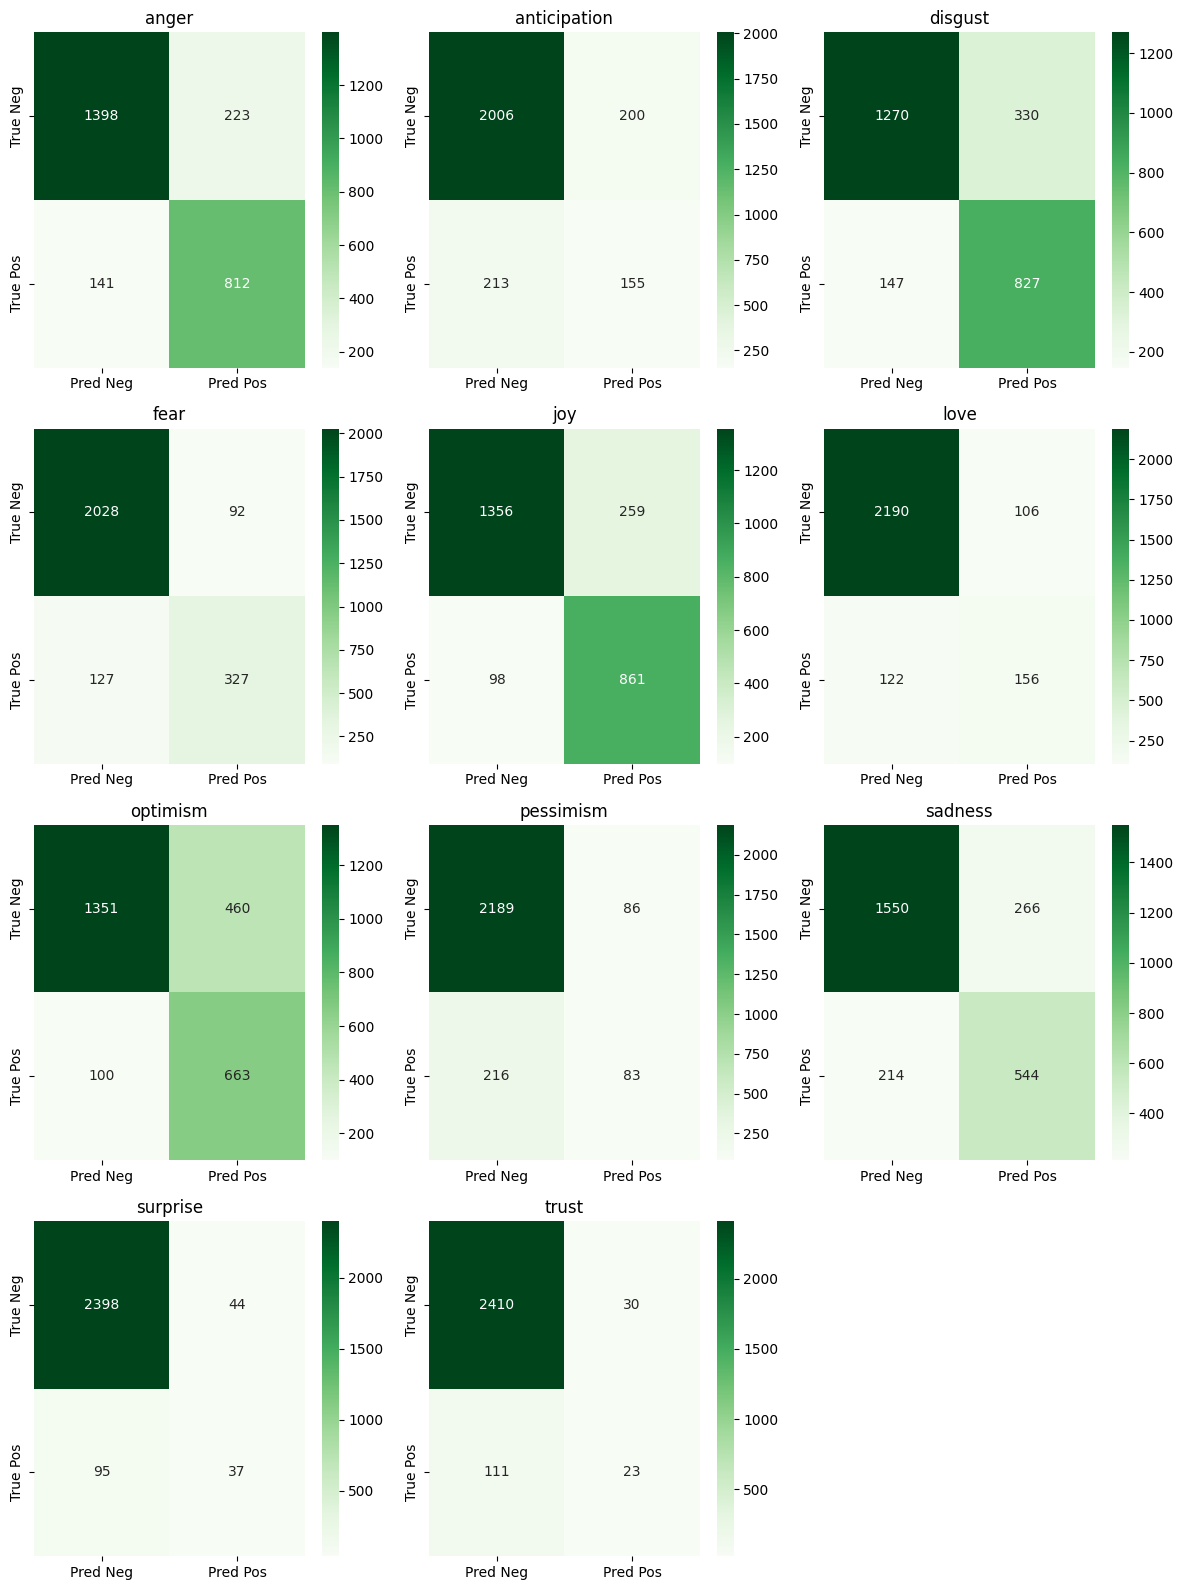

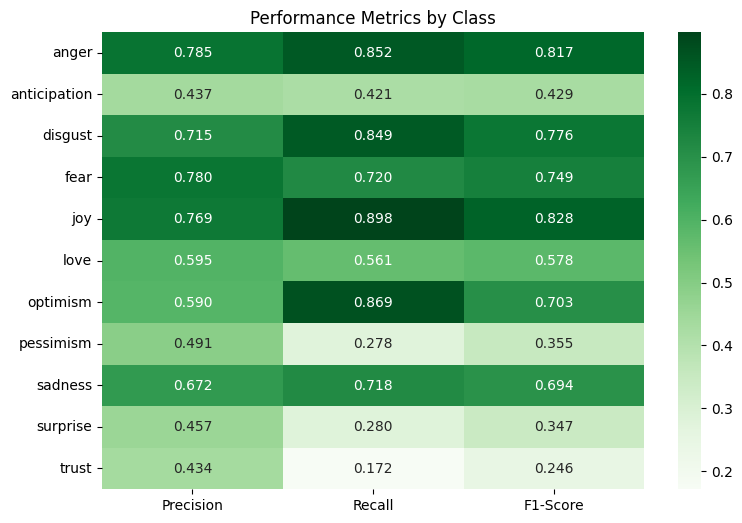

<Figure size 1200x533.333 with 0 Axes>

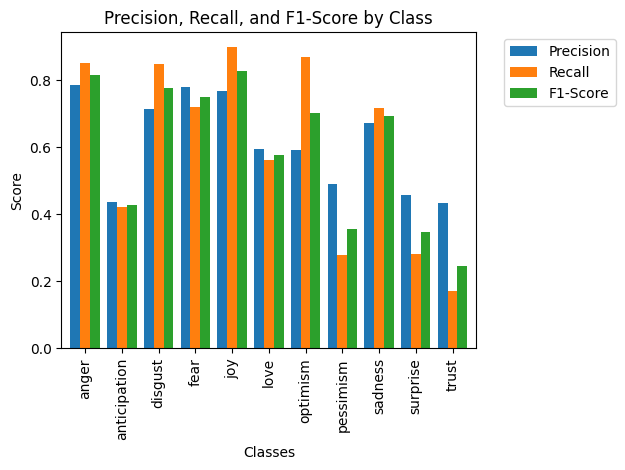

{'macro_avg': {'precision': 0.6113094831186445,
  'recall': 0.6016087917020428,
  'f1': 0.5929176540959276},
 'per_class': {'Precision': {'anger': 0.7845410628019324,
   'anticipation': 0.43661971830985913,
   'disgust': 0.7147796024200519,
   'fear': 0.7804295942720764,
   'joy': 0.76875,
   'love': 0.5954198473282443,
   'optimism': 0.5903829029385574,
   'pessimism': 0.4911242603550296,
   'sadness': 0.671604938271605,
   'surprise': 0.4567901234567901,
   'trust': 0.4339622641509434},
  'Recall': {'anger': 0.8520461699895068,
   'anticipation': 0.421195652173913,
   'disgust': 0.8490759753593429,
   'fear': 0.7202643171806168,
   'joy': 0.8978102189781022,
   'love': 0.5611510791366906,
   'optimism': 0.8689384010484927,
   'pessimism': 0.27759197324414714,
   'sadness': 0.7176781002638523,
   'surprise': 0.2803030303030303,
   'trust': 0.17164179104477612},
  'F1-Score': {'anger': 0.8169014084507042,
   'anticipation': 0.4287690179806362,
   'disgust': 0.7761614265603003,
   'fear

In [ ]:
multilabel_evaluation(y_true=valid_labels_binary, y_pred=valid_predictions_binary, class_names=class_names, figsize=(12, 8))

# <font color='pickle'>**7. Model Inference**

In [ ]:
# loading in the test data
test_ds = joblib.load(data_folder/'X_test_cleaned.pkl')

In [ ]:
test_df = pd.DataFrame(test_ds).T # transposing
test_df.rename(columns = {0:'text', 1:'label'}, inplace = True)
print(test_df.head())
print("-"*30)
print(test_df.shape)
print('There are no labels for the entire test set.')

                                                text  \
0  @Adnan__786__ @AsYouNotWish Dont worry Indian ...   
1  Academy of Sciences, eschews the normally sobe...   
2                  I blew that opportunity -__- #mad   
3             This time in 2 weeks I will be 30... 😥   
4  #Deppression is real. Partners w/ #depressed p...   

                                               label  
0  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
1  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
2  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
3  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
4  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
------------------------------
(3259, 2)
There are no labels for the entire test set.


In [ ]:
test_ids = joblib.load(data_folder/'test_ids.pkl')
test_ids.head()

,ID
0,2018-01559
1,2018-03739
2,2018-00385
3,2018-03001
4,2018-01988


In [ ]:
test_ds = test_df.drop(columns = {'label'}) # dropping the missing labels from the dataset

In [ ]:
# Function to assign random non-duplicate labels to each text
def assign_random_labels(class_names, max_labels=3):
    """Assign a random subset of non-duplicate labels."""
    num_labels = random.randint(1, max_labels)  # Randomly decide how many labels to assign
    return random.sample(class_names, num_labels)

test_ds['label'] = [assign_random_labels(class_names) for _ in range(len(test_ds))]


In [ ]:
test_ds

,text,label
0,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,"[fear, love]"
1,"Academy of Sciences, eschews the normally sobe...",[surprise]
2,I blew that opportunity -__- #mad,[fear]
3,This time in 2 weeks I will be 30... 😥,"[optimism, anticipation, fear]"
4,#Deppression is real. Partners w/ #depressed p...,[disgust]
...,...,...
3254,shaft abrasions from panties merely shifted to...,"[sadness, surprise, love]"
3255,@lomadia heard of Remothered? Indie horror gam...,"[disgust, surprise]"
3256,All this fake outrage. Y'all need to stop 🤣,"[trust, surprise, fear]"
3257,Would be ever so grateful if you could record ...,"[optimism, disgust]"


In [ ]:
test_ds = Dataset.from_pandas(test_ds)

In [ ]:
test_ds['text'][:5]

['@Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell',
 'Academy of Sciences, eschews the normally sober tone of scientific papers and calls the massive loss of wildlife a “biological annihilation',
 'I blew that opportunity -__- #mad',
 'This time in 2 weeks I will be 30... 😥',
 '#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse']

In [ ]:
test_ds['label'][:5]

[['fear', 'love'],
 ['surprise'],
 ['fear'],
 ['optimism', 'anticipation', 'fear'],
 ['disgust']]

In [ ]:
test_ds = test_ds.map(format_chat_inference)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
test_ds = test_ds.filter(check_length)

Filter:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
test_ds['text'][:5]

["<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 07 Dec 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'].\n\nTEXT: @Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n",
 "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 07 Dec 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'].\n\nTEXT: Academy of Sciences, eschews the normally sober tone of sc

In [ ]:
test_ds[:5]

{'text': ["<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 07 Dec 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'].\n\nTEXT: @Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n",
  "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 07 Dec 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'].\n\nTEXT: Academy of Sciences, eschews the normally sober 

In [ ]:
# Check for missing or invalid text
for idx, row in enumerate(test_ds):
    if row["text"] is None or not isinstance(row["text"], str):
        print(f"Invalid text at index {idx}: {row['text']}")

# Check for missing or invalid labels
for idx, row in enumerate(test_ds):
    if row["label"] is None or not isinstance(row["label"], list):
        print(f"Invalid label at index {idx}: {row['label']}")

In [ ]:
test_ds = test_ds.filter(lambda x: x["text"] is not None and isinstance(x["label"], list))

Filter:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
free_gpu_memory()
model = AutoPeftModelForCausalLM.from_pretrained(
    checkpoint,
    quantization_config=bnb_config,
    torch_dtype=torch_data_type,
    trust_remote_code=True,
    device_map='auto'
)
model.device
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = '<|finetune_right_pad_id|>'
tokenizer.padding_side = 'left'

GPU memory has been freed.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
inference_results = run_inference_instruction(seed = 42,
                                              dataset = test_ds,
                                              model = model,
                                              tokenizer = tokenizer,
                                              per_device_batch_size = 40,
                                              input_field = 'text',
                                              output_field = 'label')

Generating Predictions: 100%|██████████| 82/82 [03:31<00:00,  2.57s/it]


In [ ]:
extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in inference_results
]

# Clean and convert predictions and ground truth
predictions = [
    clean_and_split_labels(extracted_output, class_names)
    for extracted_output in extracted_outputs

]

In [ ]:
predictions[:5]

[['anger', 'disgust', 'fear', 'optimism'],
 ['anger', 'disgust', 'sadness'],
 ['anger', 'disgust', 'sadness'],
 ['fear', 'sadness'],
 ['fear', 'pessimism', 'sadness']]

In [ ]:
def get_prediction_labels(predictions, class_names, df_test_ids):
  """
  This function processes the pipeline output of generated model labels and generates the binary predictions for each observation.
  The predictions are binarized based on the presence of each label in the pipeline output for the test set.

  Parameters:
  - predictions: The output from the model inference. (A list of lists containing the labels for each observation)
  - class_names: The emotion class names from the given dataset.
  - df_test_ids: A dataframe that containing the ID's as the primary key for the test set. (Contains an 'ID' column)

  Returns:
  - df_pred_final: A pandas DataFrame with the appropriate test ID linked with its binary predictions.
  """

  # 1. Prepare the binary predictions (1 if the label was predicted else 0)
  binary_predictions = [] # empty list for the predictions
  for pred_set in predictions:
    # Intitialize a list of 0's for each class.
    binary_preds = [1 if class_name in pred_set else 0 for class_name in class_names]
    binary_predictions.append(binary_preds)

  # 2. Convert the binary predictions to a DataFrame
  df_predictions = pd.DataFrame(binary_predictions, columns = class_names)

  # 3. Concatenate the ID's to the dataframe
  df_pred_final = pd.concat([df_test_ids.reset_index(drop=True), df_predictions], axis=1)

  # 4. Set the index of df_pred_final to be the ID column
  df_pred_final = df_pred_final.set_index('ID')

  return df_pred_final


In [ ]:
df_pred_final = get_prediction_labels(predictions, class_names, test_ids)

In [ ]:
df_pred_final.sum()

,0
anger,1193
anticipation,338
disgust,1297
fear,434
joy,1630
love,471
optimism,1600
pessimism,150
sadness,1018
surprise,84


In [ ]:
df_pred_final.shape

(3259, 11)

In [ ]:
df_pred_final.head()

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
ID,,,,,,,,,,,
2018-01559,1,0,1,1,0,0,1,0,0,0,0
2018-03739,1,0,1,0,0,0,0,0,1,0,0
2018-00385,1,0,1,0,0,0,0,0,1,0,0
2018-03001,0,0,0,1,0,0,0,0,1,0,0
2018-01988,0,0,0,1,0,0,0,1,1,0,0


In [ ]:
df_pred_final.to_csv(base_folder/'predictions_llama_it.csv')